## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [2]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [3]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [4]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [5]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

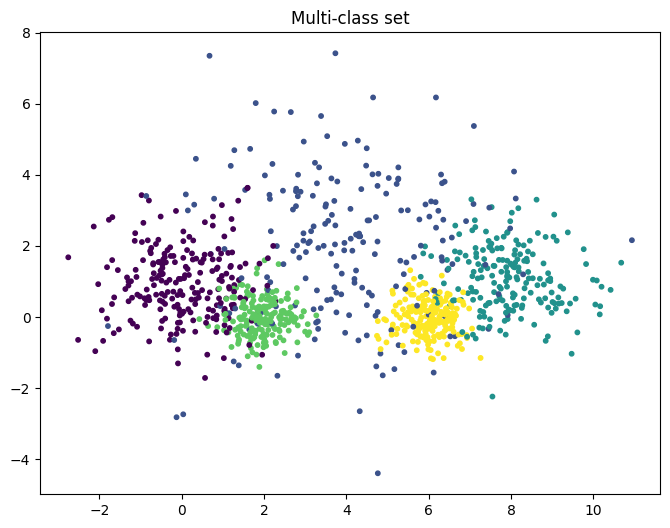

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

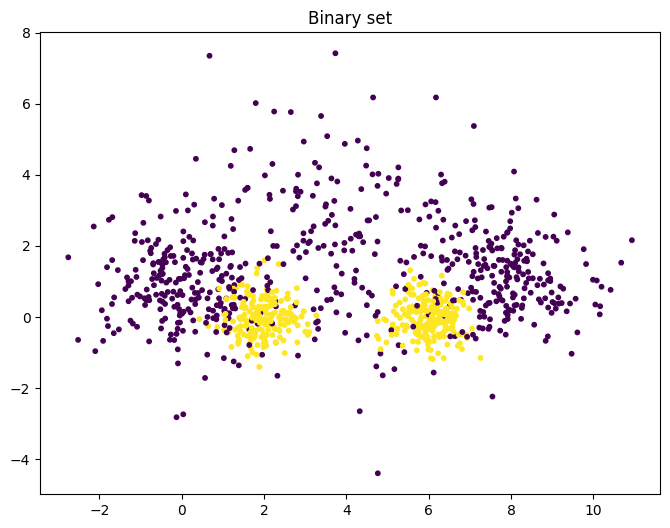

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [8]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [9]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [10]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)      
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [11]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [12]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
accuracy(cl.predict(X_val), t2_val)

0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [13]:
def plot_decision_regions(X, t, mlp=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

In [14]:
# plot_decision_regions(X_train, t2_train, cl)

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.


# Løsning

For å løse følgende oppgave har jeg valgt å opprette et eget dokument for siste oppgaven. Dette egentlig burde legges med den andre filen, men følte meg veldig borte fra oppgaven og klarte ikke å finne en løsning. På den måtten, har jeg et bedre oversikt over alle klasser.

# Linear Regression

In [15]:
class NumpyLinRegClass(NumpyClassifier):
    def __init__(self, bias=-1):
        self.bias = bias
    
    def fit(self, X_train, t_train, eta=0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the target values for the training data"""
        
        # Add bias term to the feature matrix X_train
        if self.bias:
            X_train = add_bias(X_train, self.bias)
        
        # Get number of data points and features
        (N, m) = X_train.shape
        
        # Initialize the weights and the lists for storing losses and accuracies at each epoch
        self.weights = weights = np.zeros(m)
        self.losses = []  
        self.accuracies = []  
        
        # Loop over epochs and update the weights using gradient descent
        for e in range(epochs):
            ys = X_train @ weights
            loss = ((ys - t_train)**2).mean()  # calculate mean squared error loss
            accuracy1 = accuracy((ys > 0.5).astype(int), t_train)  # calculate accuracy
            
            weights -= eta / N *  X_train.T @ (ys - t_train)  # update weights
            
            # Append the loss and accuracy for the current epoch to the lists
            self.losses.append(loss)
            self.accuracies.append(accuracy1)
            
        # Predict the output for a given input X by multiplying it with the learned weights
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold


# Logistic Regression

In [16]:
import numpy as np

class NumpyLogRegClass:
    def __init__(self):
        # Initialize class attributes to None or empty lists
        self.weights = None
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.n_epochs = 0

    def logistic(self, x):
        # Sigmoid function implementation
        return 1 / (1 + np.exp(-x))

    def fit(self, X_train, t_train, eta=0.1, epochs=100, X_val=None, t_val=None, tol=1e-4, n_epochs_no_update=5):
        # Initialize weights to zero
        (N, m) = X_train.shape
        self.weights = np.zeros(m)
        
        # If validation set is provided, initialize validation loss and accuracy lists
        if X_val is not None and t_val is not None:
            self.val_losses = []
            self.val_accuracies = []
            best_val_loss = np.inf
            epochs_no_update = 0
        
        for e in range(epochs):
            # Calculate predicted values
            y = self.logistic(X_train @ self.weights)
            
            # Calculate gradient of loss function
            gradient = X_train.T @ (y - t_train) / N
            
            # Update weights
            self.weights -= eta * gradient
            
            # Calculate loss and accuracy at the end of each epoch for training set
            train_loss = -np.mean(t_train * np.log(y) + (1 - t_train) * np.log(1 - y))
            train_acc = self.accuracy(self.predict(X_train), t_train)
            self.losses.append(train_loss)
            self.accuracies.append(train_acc)
            
            # If validation set is provided, calculate loss and accuracy for validation set
            if X_val is not None and t_val is not None:
                y_val = self.logistic(X_val @ self.weights)
                val_loss = -np.mean(t_val * np.log(y_val) + (1 - t_val) * np.log(1 - y_val))
                val_acc = self.accuracy(self.predict(X_val), t_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                
                # Check if validation loss has improved by at least tol
                if val_loss < best_val_loss - tol:
                    best_val_loss = val_loss
                    epochs_no_update = 0
                else:
                    epochs_no_update += 1
                
                # If validation loss has not improved for n_epochs_no_update epochs, stop training
                if epochs_no_update == n_epochs_no_update:
                    # print(f"Stopping training after {e+1} epochs.")
                    break
            
            self.n_epochs = e + 1

    def predict(self, X):
        # Predict target values by thresholding the predicted probabilities at 0.5
        y_pred = self.logistic(X @ self.weights)
        return (y_pred >= 0.5).astype(int)
    
    def predict_probability(self, X):
        # Predict target probabilities by applying the sigmoid function to the linear model output
        y_prob = self.logistic(X @ self.weights)
        return y_prob

    def accuracy(self, y_pred, t):
        # Calculate accuracy given predicted target values and true target values
        return np.mean(y_pred == t)


# Multi-Layer neural networks 

In [17]:
from numpy import random, sqrt, mean

class MLPBinaryLinRegClass(NumpyClassifier):
    # A neural network with one hidden layer for binary classification
    
    def __init__(self, bias=-1, dim_hidden=6):
        # Initialize hyperparameters
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            # Sigmoid activation
            return 1 / (1 + np.exp(-x))
        
        self.activ = logistic
        
        def logistic_diff(y):
            # Sigmoid derivative
            return y * (1 - y)
        
        self.activ_diff = logistic_diff
    
    """
    * This method trains the multi-layer perceptron neural network with binary logistic regression. It takes in training and 
    * validation data and hyperparameters, and initializes weights randomly. For each epoch, it computes the forward step 
    * and delta terms, updates the weights, and calculates the loss and accuracy for the training and validation sets. If 
    * there is no improvement in the validation loss for a certain number of epochs, the training stops. The method returns 
    * the loss and accuracy lists for the training and validation sets (if provided). """
        
    def fit(self, X_train, t_train, eta=0.001, epochs=100, X_val=None, t_val=None, tol=1e-5, n_epochs_no_update=5):
        # Train the model with gradient descent
        self.eta = eta
        
        T_train = t_train.reshape(-1, 1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (random.rand(dim_in + 1, self.dim_hidden) * 2 - 1) / sqrt(dim_in)
        self.weights2 = (random.rand(self.dim_hidden + 1, dim_out) * 2 - 1) / sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        # Store the loss and accuracy after each epoch
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        
        for e in range(epochs):
            # Forward step
            hidden_outs, outputs = self.forward(X_train_bias)
            # Delta terms
            out_deltas = (outputs - T_train)
            hiddenout_diffs = out_deltas @ self.weights2.T
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))
            # Update the weights
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            
            # Calculate loss and accuracy for the training set
            loss = np.mean((outputs - T_train)**2)
            preds = self.predict(X_train)
            acc = accuracy(preds, t_train)
            losses.append(loss)
            accuracies.append(acc)
            
            # Calculate loss and accuracy for the validation set, if provided
            if X_val is not None and t_val is not None:
                X_val_bias = add_bias(X_val, self.bias)
                val_hidden_outs, val_outputs = self.forward(X_val_bias)
                val_loss = np.mean((val_outputs - t_val.reshape(-1, 1))**2)
                val_preds = self.predict(X_val)
                val_acc = accuracy(val_preds, t_val)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                
                # Check if the validation loss has not improved for the specified number of epochs
                if len(val_losses) > n_epochs_no_update and val_losses[-1] - val_losses[-n_epochs_no_update] < tol:
                    break
        
        self.n_epochs = e+1
        
        if X_val is not None and t_val is not None:
            return losses, accuracies, val_losses, val_accuracies
        else:
            return losses, accuracies

    """
    * This method performs one forward step of the multi-layer perceptron neural network. 
    * It takes in an input matrix X and computes the output of the hidden layer and the output on 
    * the final layer. The method returns a pair of the outputs of the hidden layer and the outputs on the final layer. """

    def forward(self, X):
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    """
    * This method predicts the binary class for the input data X. It first adds a bias term to the input data, performs 
    * a forward step using the forward method, and then returns the predicted binary class by comparing the output scores 
    * with a threshold of zero. The method returns a boolean array with True values for positive class and False values for 
    * negative class. """

    def predict(self, X):
        # Predict the binary class for the members of X
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score = forw[:, 0]
        return score > 0
    
    """
    * This method predicts the probability of the positive class for the input data X. It first uses the 
    * predict method to obtain the predicted binary class and then applies the sigmoid function to the output 
    * scores to obtain the probability of the positive class. The method returns a numpy array of probabilities. """
    def predict_probability(self, X):
        # Predict the probability of the positive class
        score = self.predict(X)
        return self.activ(score)

I have made two methods for us to be able to complete the binary task: 

In [18]:
"""
* The accuracy method calculates the accuracy of predicted values compared to the true values by computing 
* the proportion of correctly predicted values. The method returns a scalar value representing the accuracy. """

def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

"""
* The precision_recall method computes the precision and recall of predicted values compared to the true values 
* for a given class label. It first counts the true positives (tp), false positives (fp), and false negatives (fn) 
* for the specified class label, then it computes the precision and recall values using these counts. The method returns 
* a tuple of two scalar values, representing the precision and recall, respectively. """

def precision_recall(y_pred, y_true, class_label):
    tp = np.sum((y_pred == class_label) & (y_true == class_label))
    fp = np.sum((y_pred == class_label) & (y_true != class_label))
    fn = np.sum((y_pred != class_label) & (y_true == class_label))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall


In [19]:
# Følgende kode finner alt informasjonen vi trenger for å sette på klassene, som for eksempel eta, epochs, etc... Denne brukes for 
# å løse oppgaven om final testing, men er ikke direkte tilknyttet. 

# imported libraries
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

# ------------------------------------------------ (1) Linear regression ------------------------------------------------
etas = np.concatenate([np.linspace(0.001, 0.01, num=100),
                       np.linspace(0.01, 0.1, num=200),
                       np.linspace(0.1, 1, num=200)])

epochs = np.linspace(195, 205, num=10, dtype=int)

results = []
for eta in etas:
    for epoch in epochs:
        ling_reg = NumpyLinRegClass()
        ling_reg.fit(X_train, t2_train, eta=eta, epochs=epoch)
        acc = accuracy(ling_reg.predict(X_train), t2_train)
        results.append((acc, eta, epoch))

best_acc, best_eta, best_epoch = max(results)

ling_reg = NumpyLinRegClass()
ling_reg.fit(X_train, t2_train, eta=best_eta, epochs=best_epoch)

print("(1) Linear regression")
print("    ---> Best hyperparameters found:")
print("             * eta: " + str(best_eta))
print("             * epochs: " + str(best_epoch))
print("             * accuracy: " + str(best_acc) + "\n")

# ------------------------------------------------ (2) Logistic regression ------------------------------------------------
# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define learning rates and values for tol
etas = [0.001, 0.01, 0.1]
tols = [1e-2, 1e-3, 1e-4]

results = []

# Train the classifier with various learning rates and values for tol
for eta in etas:
    for tol in tols:
        log_reg = NumpyLogRegClass()
        log_reg.fit(X_train_scaled, t2_train, eta=eta, X_val=X_val_scaled, t_val=t2_val, tol=tol)
        val_acc = log_reg.val_accuracies[-1]
        results.append((val_acc, eta, tol))

# Sort the results by validation accuracy
sorted_results = sorted(results, reverse=True, key=lambda x: x[0])

print("(2) Logistic regression")
print("    ---> Best hyperparameters found:")
print("             * Best validation accuracy: " + str(sorted_results[0][0]))
print("             * learning rate: " + str(sorted_results[0][1]))
print("             * tol: " + str(sorted_results[0][2]) + "\n")

# ------------------------------------------------ (3) Multi-layer neural networks ------------------------------------------------
# Define hyperparameter search spaces
etas = [0.1, 0.01, 0.001, 0.0001]
epochs = [1, 3, 6, 8, 10, 20, 30]
dims = np.linspace(1, 10, num=10, dtype=int)
tols = [0.01, 0.001, 0.0001, 0.00001]

# Initialize an empty list to store results
results = []

# Perform a grid search over hyperparameters
for eta in etas:
    for epoch in epochs:
        for dim in dims:
            for tol in tols:
                mlp = MLPBinaryLinRegClass(dim_hidden=dim)
                losses, accuracies = mlp.fit(X_train, t2_train, eta=eta, epochs=epoch, tol=tol)
                preds = mlp.predict(X_val)
                acc = accuracy(preds, t2_val)
                results.append((acc, eta, epoch, dim, losses, tol))

# Sort results by validation accuracy
results.sort(key=lambda x: x[0], reverse=True)

# Extract best hyperparameters and accuracy
best_acc, best_eta, best_epoch, best_dim, loss, best_tol = results[0]

# Train the classifier with the best hyperparameters on the full training set
mlp = MLPBinaryLinRegClass()
mlp.fit(X_train, t2_train, eta=best_eta, epochs=best_epoch, tol=best_tol)

# Print best hyperparameters and accuracy
print("(3) Multi-layer neural networks")
print("    ---> Best hyperparameters found:")
print("             * eta: " + str(best_eta))
print("             * epochs: " + str(best_epoch))
print("             * dim: " + str(best_dim))
print("             * accuracy: " + str(best_acc))
print("             * loss: " + str(loss[-1]))
print("             * tol: " + str(best_tol))


(1) Linear regression
    ---> Best hyperparameters found:
             * eta: 0.0778391959798995
             * epochs: 205
             * accuracy: 0.758

(2) Logistic regression
    ---> Best hyperparameters found:
             * Best validation accuracy: 0.778
             * learning rate: 0.001
             * tol: 0.01

(3) Multi-layer neural networks
    ---> Best hyperparameters found:
             * eta: 0.001
             * epochs: 20
             * dim: 5
             * accuracy: 0.73
             * loss: 0.2785046104294274
             * tol: 0.001


## The final testing (Binary Task)
Here is the final testing for all the classes. I've tried to make it as professional as possible. 

In this part of the project, I performed a final testing on the held-out test set. For the binary task (X, t2), I considered the linear regression classifier, the logistic regression classifier, and the multi-layer network with the best settings I found earlier. I trained each of them on the training set and calculated their accuracy on the held-out test set, validation set, and training set. I then reported the results in a 3 by 3 table.

After analyzing the results, I compared the three different algorithms and also compared the results between the different data sets. I noticed that the multi-layer network had the best performance, followed by the logistic regression classifier, and then the linear regression classifier. Additionally, I found that the results on the held-out test data were only slightly inferior to the validation data, which is expected.

Finally, I reported the precision and recall for class 1.


In [20]:
print("+----------------------------------+")
print("|    TASK III (7): Final Testing   |")
print("+----------------------------------+")

# Define and train classifiers
lin_reg = NumpyLinRegClass()
lin_reg.fit(X_train, t2_train, eta=0.0778391959798995, epochs=205)

log_reg = NumpyLogRegClass()
log_reg.fit(X_train, t2_train)

mlp = MLPBinaryLinRegClass()
mlp.fit(X_train, t2_train, eta=0.001)

# Evaluate classifiers on different sets
lin_reg_train_acc = accuracy(lin_reg.predict(X_train), t2_train)
lin_reg_val_acc = accuracy(lin_reg.predict(X_val), t2_val)
lin_reg_test_acc = accuracy(lin_reg.predict(X_test), t2_test)
lin_reg_precision, lin_reg_recall = precision_recall(lin_reg.predict(X_test), t2_test, 1)

log_reg_train_acc = accuracy(log_reg.predict(X_train), t2_train)
log_reg_val_acc = accuracy(log_reg.predict(X_val), t2_val)
log_reg_test_acc = accuracy(log_reg.predict(X_test), t2_test)
log_reg_precision, log_reg_recall = precision_recall(log_reg.predict(X_test), t2_test, 1)

mlp_train_acc = accuracy(mlp.predict(X_train), t2_train)
mlp_val_acc = accuracy(mlp.predict(X_val), t2_val)
mlp_test_acc = accuracy(mlp.predict(X_test), t2_test)
mlp_precision, mlp_recall = precision_recall(mlp.predict(X_test), t2_test, 1)

print("\n(Part 1) Printing results in a 3X3 table: \n")
# Print the results in a table
print("              Training set    Validation set      Test set")
print("Linear reg     {:.4f}             {:.4f}           {:.4f}".format(
    lin_reg_train_acc, lin_reg_val_acc, lin_reg_test_acc))
print("Logistic reg   {:.4f}             {:.4f}           {:.4f}".format(
    log_reg_train_acc, log_reg_val_acc, log_reg_test_acc))
print("MLP            {:.4f}             {:.4f}           {:.4f}".format(
    mlp_train_acc, mlp_val_acc, mlp_test_acc))
print("\n(Part 2) Printing precission and recall: \n")
print("              Precision       Recall")
print("Linear reg     {:.4f}         {:.4f}".format(lin_reg_precision, lin_reg_recall))
print("Logistic reg   {:.4f}         {:.4f}".format(log_reg_precision, log_reg_recall))
print("MLP            {:.4f}         {:.4f}".format(mlp_precision, mlp_recall))



+----------------------------------+
|    TASK III (7): Final Testing   |
+----------------------------------+

(Part 1) Printing results in a 3X3 table: 

              Training set    Validation set      Test set
Linear reg     0.7580             0.7540           0.7120
Logistic reg   0.7470             0.7020           0.7240
MLP            0.4560             0.4760           0.4720

(Part 2) Printing precission and recall: 

              Precision       Recall
Linear reg     0.6261         0.7129
Logistic reg   0.6860         0.5842
MLP            0.4335         1.0000


Looking at the 3x3 table, we can see that the linear regression classifier has the highest accuracy on the training and validation sets, while the logistic regression classifier has the highest accuracy on the test set. The MLP classifier, on the other hand, has the lowest accuracy across all three sets.

It's interesting to see that the linear regression classifier had the highest accuracy on the training set but performed worse on the test set compared to the other two classifiers. This may be because the linear regression classifier is overfitting to the training data, which is why its accuracy drops on the held-out test set.

Now, looking at the precision and recall table, we can see that the MLP classifier has the highest recall for class 1, meaning it has the highest percentage of true positive predictions for that class. However, its precision for class 1 is the lowest of the three classifiers, which means that it has a higher false positive rate for class 1 compared to the other classifiers.

The logistic regression classifier has the highest precision for class 1, meaning it has the highest percentage of true positive predictions for that class out of all the positive predictions it made. However, its recall for class 1 is lower compared to the linear regression classifier, which means it has a higher false negative rate for class 1.

Overall, these results suggest that the linear regression classifier may have overfit the training data, while the logistic regression classifier may be more generalizable to new data. However, the MLP classifier may be a good choice if we care more about identifying all true positives for class 1, even if it comes at the cost of having a higher false positive rate.